In [1]:
import pandas as pd
import os
import sys
sys.path.append('/cellar/users/snwright/Git/rare_common/carva')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import sklearn.preprocessing as prep
import statsmodels.api as sm

import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
datadir='/cellar/users/snwright/Data/RareCommon'
inputdir=os.path.join(datadir, 'inputs')
annotdir=os.path.join(datadir, 'outputs/Features')
outdir=os.path.join(datadir, 'outputs/netcoloc/March_2025')
keydir=os.path.join(datadir, 'outputs/key_files')
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/Regression'

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'

# Load data

## Load NetColoc results

In [4]:
best_df = pd.read_csv(os.path.join(keydir, 'best_coloc_overlap.txt'), sep='\t')
best_df = best_df.rename(columns={'trait_type_x':'trait_type'})


In [5]:
initial_df = pd.read_csv(os.path.join(keydir, 'initial_coloc_overlap.txt'), sep='\t')
repeat_df = pd.read_csv(os.path.join(keydir, 'repeat_coloc_overlap.txt'), sep='\t')

In [6]:
initial_df.shape

(373, 24)

In [149]:
info_df = pd.concat([initial_df, repeat_df])
info_df.to_csv(os.path.join(keydir, 'all_coloc.tsv'), sep='\t')
#info_df = info_df[info_df.trait_pair.isin(best_df.trait_pair.values)]

## Load additional meta data

In [8]:
study_df = pd.read_csv(os.path.join(keydir, 'all_study_info.txt'), sep='\t', index_col=0)
study_df['N_C'] = study_df.apply(lambda x: x.N_C if x['PUBMED ID']!=34610981 else 5705, axis=1)
domain_info = pd.read_csv(os.path.join(keydir, 'domain_trait_type.txt'), sep='\t', index_col=0).drop_duplicates()
best_df = best_df.merge(domain_info.loc[:, ('EFO', 'Domain')], on=['EFO'], how='left')
info_df = info_df.merge(domain_info, on=['EFO'], how='left')
best_df = info_df[info_df.trait_pair.isin(best_df.trait_pair.values)]

In [9]:
input_df = pd.read_csv(os.path.join(keydir, 'Features_input.txt'), sep='\t')
input_df.head()

,trait_pair,N_R,N_C,Cosine_R,Cosine_C,log2SizeOE,logp_size,n_common,n_rare,n_overlap,pval,trait_type,jaccard,binary,jaccard_zero,Gene_ratioRC,overlap_logp
0,34226706_EFO_0004833_GCST90002355_EFO_0004833,443782.000000,627215.0,0.934107,1.0,1.312189,134.333857,200,22,1,2.217872e-02,Q,0.004525,0,0,0.110000,1.654063
1,34662886_EFO_0004833_GCST90002355_EFO_0004833,418407.159091,627215.0,0.907560,1.0,1.551702,250.000000,200,16,5,9.257339e-09,Q,0.023697,0,0,0.080000,8.033514
2,28089252_EFO_0004833_GCST90025977_EFO_0004833,1860.000000,443782.0,1.000000,1.0,1.387722,157.049927,9,7,0,3.311603e-03,Q,0.000000,0,1,0.777778,2.479962
3,34226706_EFO_0004833_GCST90025977_EFO_0004833,443782.000000,443782.0,0.934107,1.0,1.993424,250.000000,9,22,6,3.460779e-20,Q,0.240000,0,0,2.444444,19.460826
4,34662886_EFO_0004833_GCST90025977_EFO_0004833,418407.159091,443782.0,0.907560,1.0,2.285295,250.000000,9,16,6,2.322757e-21,Q,0.315789,0,0,1.777778,20.633996


## Load genesets

In [10]:
best_pairs = best_df.trait_pair.values

In [11]:
all_pairs = info_df.trait_pair.values

## Load network features

In [12]:
all_net = pd.read_csv(os.path.join(keydir, 'Features_network.txt'), sep='\t', index_col=0)
all_net.head()

,trait_pair,varset,EFO,subnetwork_density,n_components,average_degree,subnetwork_average_degree,clustering,subnetwork_clustering,assortativity,average_path,subnetAssort,n_rare,n_common,n_overlap,Modularity,SubnetMod
0,19847924_EFO_0001645_GCST010866_EFO_0001645,common,EFO_0001645,0.045558,16.0,413.545455,4.464646,0.229699,0.214016,0.005511,2.138528,NaN,6.0,99.0,0.0,5.826298e-05,NaN
1,19847924_EFO_0001645_GCST010866_EFO_0001645,overlap,EFO_0001645,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,6.0,99.0,0.0,0.000000e+00,NaN
2,19847924_EFO_0001645_GCST010866_EFO_0001645,rare,EFO_0001645,0.000000,6.0,221.333333,0.000000,0.442379,0.000000,-0.000172,2.400000,NaN,6.0,99.0,0.0,-5.942470e-08,NaN
3,19847924_EFO_0001645_GCST010866_EFO_0001645,rare_common,EFO_0001645,0.042491,19.0,402.561905,4.419048,0.237879,0.196440,0.005521,2.150366,-0.024283,6.0,99.0,0.0,6.025068e-05,-0.001124
4,19847924_EFO_0001645_GCST010866_EFO_0001645,subnetwork,EFO_0001645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.124034e-03,NaN


## Load bio features

In [13]:
bio_df = pd.read_csv(os.path.join(keydir, 'Features_bio_genesets.txt'), sep='\t', index_col=0)
bio_df.head()

,Cite,MisSyn,Disgen,pli,omim,Length,GO,CDS,mrna,n_mrna,Set
34662886_EFO_0007990,252.0,0.173800,51.0,3.10990,2.0,39697.0,27.0,1648.0,14.994072,54.0,Rare
34662886_EFO_0009188,164.5,0.132780,18.5,2.13540,1.0,34386.5,18.5,1919.0,31.607481,54.0,Rare
34375979_EFO_0002496,111.0,-0.847240,18.0,1.30470,2.0,26500.0,13.0,1236.0,12.647432,5.0,Rare
34244158_EFO_0000756,45.0,0.614420,2.0,1.68090,0.0,29715.0,15.0,2052.0,7.181628,53.0,Rare
34375979_EFO_1001494,29.0,0.070331,3.0,0.48484,0.0,33148.0,8.0,1238.0,7.208555,41.0,Rare


# Initial feature engineering and correlations

## Input features

In [14]:
input_df.head()

,trait_pair,N_R,N_C,Cosine_R,Cosine_C,log2SizeOE,logp_size,n_common,n_rare,n_overlap,pval,trait_type,jaccard,binary,jaccard_zero,Gene_ratioRC,overlap_logp
0,34226706_EFO_0004833_GCST90002355_EFO_0004833,443782.000000,627215.0,0.934107,1.0,1.312189,134.333857,200,22,1,2.217872e-02,Q,0.004525,0,0,0.110000,1.654063
1,34662886_EFO_0004833_GCST90002355_EFO_0004833,418407.159091,627215.0,0.907560,1.0,1.551702,250.000000,200,16,5,9.257339e-09,Q,0.023697,0,0,0.080000,8.033514
2,28089252_EFO_0004833_GCST90025977_EFO_0004833,1860.000000,443782.0,1.000000,1.0,1.387722,157.049927,9,7,0,3.311603e-03,Q,0.000000,0,1,0.777778,2.479962
3,34226706_EFO_0004833_GCST90025977_EFO_0004833,443782.000000,443782.0,0.934107,1.0,1.993424,250.000000,9,22,6,3.460779e-20,Q,0.240000,0,0,2.444444,19.460826
4,34662886_EFO_0004833_GCST90025977_EFO_0004833,418407.159091,443782.0,0.907560,1.0,2.285295,250.000000,9,16,6,2.322757e-21,Q,0.315789,0,0,1.777778,20.633996


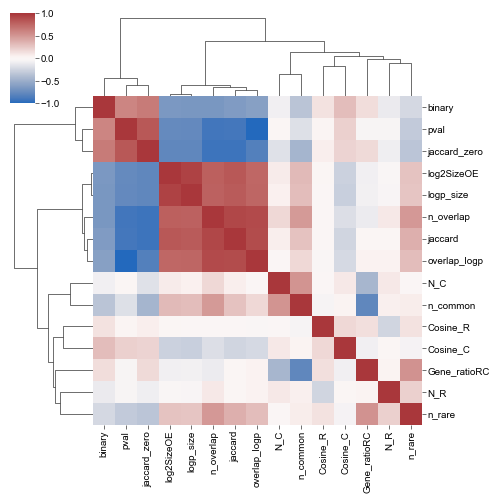

In [15]:
sns.clustermap(input_df.corr(numeric_only=True, method='spearman'), figsize=(5,5), cmap='vlag', center=0)

## Network features

In [16]:
all_net.columns

Index(['trait_pair', 'varset', 'EFO', 'subnetwork_density', 'n_components',
       'average_degree', 'subnetwork_average_degree', 'clustering',
       'subnetwork_clustering', 'assortativity', 'average_path',
       'subnetAssort', 'n_rare', 'n_common', 'n_overlap', 'Modularity',
       'SubnetMod'],
      dtype='object')

Common

top_features = subnetwork_density

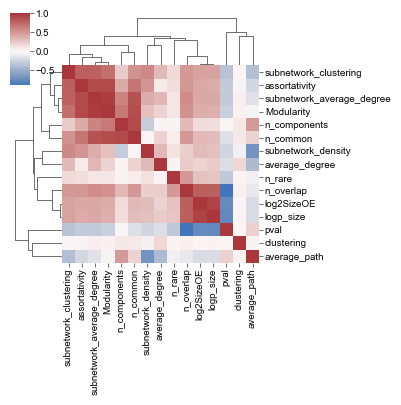

In [17]:
net_mat = all_net[all_net.varset=='common'].set_index('trait_pair').join(info_df.loc[:, 
                                        ('trait_pair', 'log2SizeOE','logp_size', 
                                          'pval', 'trait_type')].set_index('trait_pair'))
sns.clustermap(net_mat.drop(columns=['SubnetMod', 'subnetAssort']).corr(numeric_only=True, method='spearman'), figsize=(4,4), cmap='vlag', center=0)

Rare

top_features = assortativity, subnetwork_density

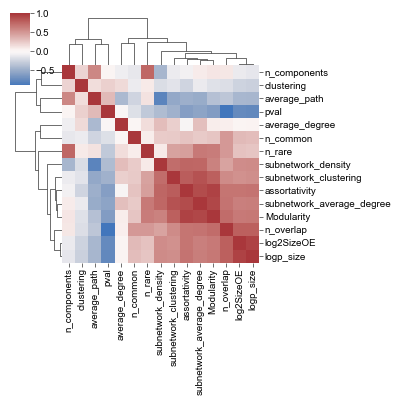

In [18]:
net_mat = all_net[all_net.varset=='rare'].set_index('trait_pair').join(info_df.loc[:, 
                                        ('trait_pair', 'log2SizeOE','logp_size', 
                                          'pval', 'trait_type')].set_index('trait_pair'))
sns.clustermap(net_mat.drop(columns=['SubnetMod', 'subnetAssort']).corr(numeric_only=True, method='spearman'), figsize=(4,4), cmap='vlag', center=0)

Overlap

top_features = None

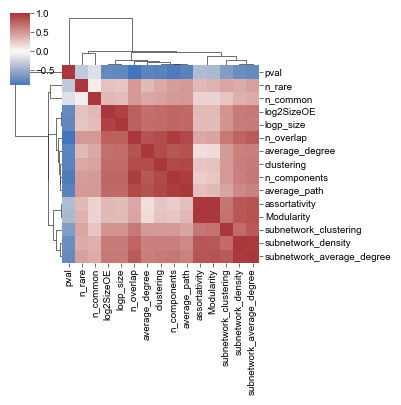

In [19]:
net_mat = all_net[all_net.varset=='overlap'].set_index('trait_pair').join(info_df.loc[:, 
                                        ('trait_pair', 'log2SizeOE','logp_size', 
                                          'pval', 'trait_type')].set_index('trait_pair'))
sns.clustermap(net_mat.drop(columns=['SubnetMod', 'subnetAssort']).corr(numeric_only=True, method='spearman'), figsize=(4,4), cmap='vlag', center=0)

rare_common

top_features = subnetwork_density, assortativity

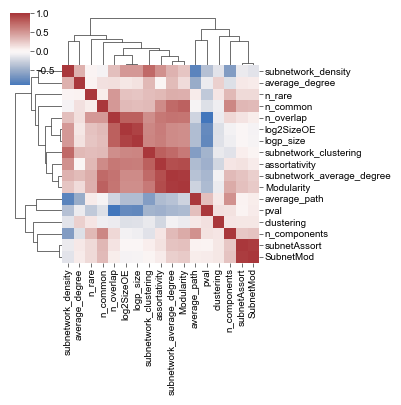

In [20]:
net_mat = all_net[all_net.varset=='rare_common'].set_index('trait_pair').join(info_df.loc[:, 
                                        ('trait_pair', 'log2SizeOE','logp_size', 
                                          'pval', 'trait_type')].set_index('trait_pair'))
sns.clustermap(net_mat.corr(numeric_only=True, method='spearman'), figsize=(4,4), cmap='vlag', center=0)

subnetwork

top_features=None

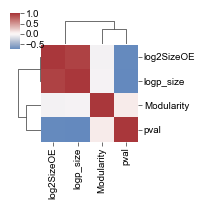

In [21]:
net_mat = all_net[all_net.varset=='subnetwork'].loc[:, ('trait_pair', 'Modularity')].set_index('trait_pair').join(info_df.loc[:, 
                                        ('trait_pair', 'log2SizeOE','logp_size', 
                                          'pval', 'trait_type')].set_index('trait_pair'))
sns.clustermap(net_mat.corr(numeric_only=True, method='spearman'), figsize=(2,2), cmap='vlag', center=0)

In [105]:
use_net = all_net.loc[~all_net.varset.isin(['subnetwork', 'overlap']), ('trait_pair', 'subnetwork_density', 'assortativity', 'varset')]

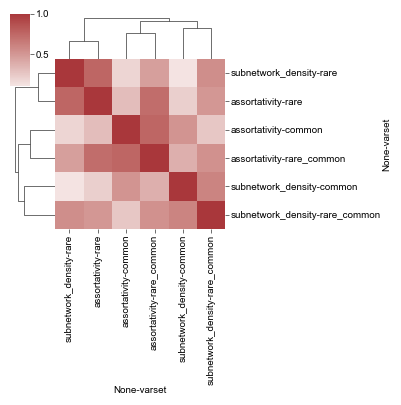

In [23]:
sns.clustermap(use_net.pivot(index='trait_pair', columns='varset', values=['subnetwork_density', 'assortativity']).corr(method='spearman'),
                             figsize=(4,4), cmap='vlag', center=0)

<Axes: xlabel='varset', ylabel='subnetwork_density'>

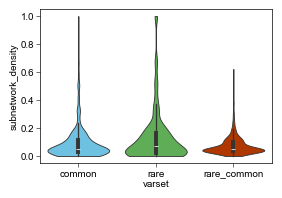

In [112]:
_ = plt.figure(figsize=(3,2))
sns.violinplot(use_net, x='varset', y='subnetwork_density', cut=0, hue='varset',  palette=[blue, green, shared],
              saturation=1)

In [24]:
use_net = use_net.pivot(index='trait_pair', columns='varset', values=['subnetwork_density', 'assortativity']).reset_index()

trait_pair subnetwork_density       \
varset                                                            common rare   
0         19847924_EFO_0001645_GCST010866_EFO_0001645           0.045558  0.0   
1         19847924_EFO_0001645_GCST011488_EFO_0001645           0.300000  0.0   
2       19847924_EFO_0001645_GCST90132305_EFO_0001645           0.008403  0.0   
3       19847924_EFO_0001645_GCST90446534_EFO_0001645           0.106061  0.0   
4       19847924_EFO_0001645_GCST90449059_EFO_0001645           0.110887  0.0   

                   assortativity                        
varset rare_common        common      rare rare_common  
0         0.042491      0.005511 -0.000172    0.005521  
1         0.072727      0.000554 -0.000172    0.000446  
2         0.007317     -0.000402 -0.000172   -0.000512  
3         0.080972      0.004771 -0.000172    0.004535  
4         0.082504      0.004464 -0.000172    0.004137

## Bio Features

In [25]:
bio_df.columns

Index(['Cite', 'MisSyn', 'Disgen', 'pli', 'omim', 'Length', 'GO', 'CDS',
       'mrna', 'n_mrna', 'Set'],
      dtype='object')

In [26]:
info_df.head(1)

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,q,param_set,n_common,n_rare,n_overlap,background,pval,trait_type,Domain,TRAIT
0,34375979_EFO_0003827,GCST90278093_EFO_0003827,pcnet2_0,neglog10,sum,0.060919,0.000596,2.038000e-16,221,219.337,...,0.902018,defaults,7,11,0,19000,0.004046,CC,Cardiovascular,pulmonary embolism


In [27]:
tR = '34375979_EFO_0003827'
tC = 'GCST90278093_EFO_0003827'
metric='Cite'
bio_df.loc[[tR, tC], [metric, 'Set']].pivot(columns='Set', values=metric)

Set,Common,Rare
34375979_EFO_0003827,NaN,120.0
GCST90278093_EFO_0003827,111.0,NaN


In [28]:
def get_mean_diff_bio_features(bio_df, metric, info_df):
    out_dict = {}
    for tR, tC, oe, j, nc, nr in tqdm(zip(info_df.TraitR.values, info_df.TraitC.values, info_df.log2SizeOE.values, 
                                  info_df.n_overlap.values, info_df.n_common.values, info_df.n_rare)):
        vals = bio_df.loc[[tR, tC], [metric, 'Set']].set_index('Set')[metric].to_dict()
        out_dict[tR+'_'+tC] = {'Min': min(vals.values()), 'Range':np.abs(vals['Rare']-vals['Common']), 
                               'Max': max(vals.values()), 'Mean': (nc*vals['Common'] + nr*vals['Rare'])/(nc+nr),
                              'DiffRC': 2*(vals['Rare']- vals['Common'])/(vals['Rare']+vals['Common']),
                              'log2SizeOE':oe, 'n_overlap':j}
    out_df = pd.DataFrame(out_dict).T
    sns.clustermap(out_df.corr(method='spearman'), figsize=(3,3), cmap='vlag', center=0)
    return out_dict

1634it [00:01, 1467.27it/s]


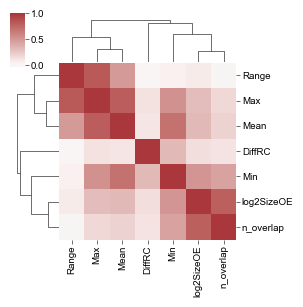

In [29]:
x = get_mean_diff_bio_features(bio_df, 'Cite', info_df)

1634it [00:01, 1483.56it/s]


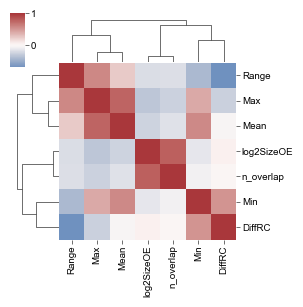

In [30]:
x = get_mean_diff_bio_features(bio_df, 'pli', info_df)

1634it [00:01, 1476.34it/s]


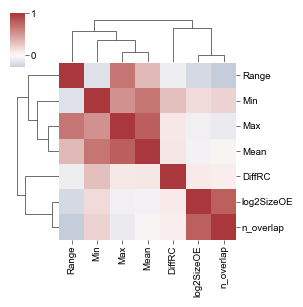

In [31]:
x = get_mean_diff_bio_features(bio_df, 'CDS', info_df)

1634it [00:01, 1478.02it/s]


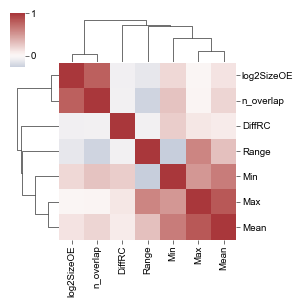

In [32]:
x = get_mean_diff_bio_features(bio_df, 'mrna', info_df)

1634it [00:01, 1475.45it/s]


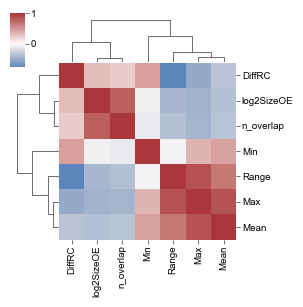

In [33]:
x = get_mean_diff_bio_features(bio_df, 'Length', info_df)

1634it [00:01, 1479.67it/s]


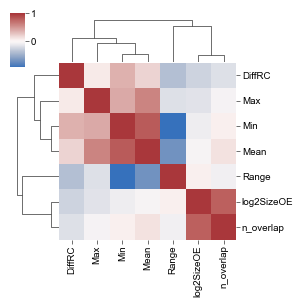

In [34]:
x = get_mean_diff_bio_features(bio_df, 'n_mrna', info_df)

1634it [00:01, 1485.79it/s]


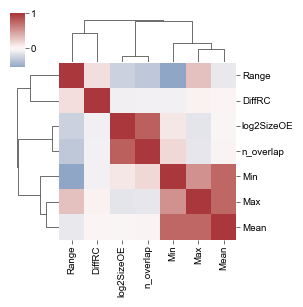

In [35]:
x = get_mean_diff_bio_features(bio_df, 'MisSyn', info_df)

In [36]:
# decision = go with mean and DiffRC
def get_mean_diff_rc(bio_df,info_df, metrics=['Cite', 'pli', 'Length', 'GO', 'mrna', 'n_mrna']):
    out_dict = {}
    for tR, tC, oe, j, nc, nr in tqdm(zip(info_df.TraitR.values, info_df.TraitC.values, info_df.log2SizeOE.values, 
                                  info_df.n_overlap.values, info_df.n_common.values, info_df.n_rare)):
        out_dict[tR+'_'+tC] = {'log2SizeOE':oe, 'n_overlap':j}
        for metric in metrics:
            vals = bio_df.loc[[tR, tC], [metric, 'Set']].set_index('Set')[metric].to_dict()
            out_dict[tR+'_'+tC][f'Mean_{metric}'] =  (nc*vals['Common'] + nr*vals['Rare'])/(nc+nr)
            out_dict[tR+'_'+tC][f'DiffRC_{metric}'] = 2*(vals['Rare']- vals['Common'])/(vals['Rare']+vals['Common'])
                                  
    out_df = pd.DataFrame(out_dict).T
    sns.clustermap(out_df.corr(method='spearman'), figsize=(3,3), cmap='vlag', center=0)
    return out_df

NameError: name 'bio_df' is not defined

1634it [00:06, 250.59it/s]


,log2SizeOE,n_overlap,Mean_Cite,DiffRC_Cite,Mean_pli,DiffRC_pli,Mean_Length,DiffRC_Length,Mean_GO,DiffRC_GO,Mean_mrna,DiffRC_mrna,Mean_n_mrna,DiffRC_n_mrna
34375979_EFO_0003827_GCST90278093_EFO_0003827,0.010897,0.0,116.500000,0.077922,2.418450,-0.892709,66381.000000,-1.737044,15.000000,0.000000,13.719068,1.299778,39.166667,0.929577
34375979_EFO_0001065_GCST90018839_EFO_0001065,0.578448,0.0,49.481481,-0.153846,1.837404,-0.498520,43157.185185,-1.363599,9.074074,0.666667,9.079306,1.046066,47.259259,0.826667
34375979_MONDO_0002253_GCST012616_MONDO_0002253,-0.253048,0.0,54.000000,-0.317597,2.401691,-0.841418,95126.756757,-1.551120,13.675676,-0.175439,13.417789,1.319138,50.216216,0.297872
28089252_EFO_0004833_GCST90002355_EFO_0004833,1.048067,0.0,73.985507,-0.500000,2.784834,-0.736202,90422.632850,-1.346396,15.101449,0.181818,11.713138,0.532370,52.864734,-0.078431
34375979_EFO_0003948_GCST90000514_EFO_0003948,0.319177,0.0,58.000000,0.466667,3.439471,-1.082920,212631.714286,-1.686052,16.857143,0.318841,11.014632,1.043169,45.428571,0.248649


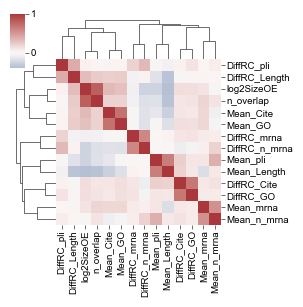

In [37]:
bio_feat = get_mean_diff_rc(bio_df, info_df)
bio_feat.head()

## Combined Features

In [38]:
net_features = [['subnetwork_density', 'rare'], 'subnetwork_density-common', 'assortativity-rare_common']
net_feat = use_net.loc[:, [('trait_pair', ''), ('subnetwork_density', 'rare'), ('subnetwork_density', 'common'), ('assortativity', 'rare_common')]]
net_feat.columns=['trait_pair', 'subnetwork_density_rare', 'subnetwork_density_common', 'assortativity_rare_common']
net_feat = net_feat.set_index('trait_pair')

In [39]:
input_feat = input_df.loc[:, ['trait_pair', 'binary', 'jaccard', 'jaccard_zero', 'n_rare', 'n_common', 'N_C', 'N_R', 'log2SizeOE']].set_index('trait_pair')
input_feat.index.name=''

In [40]:
all_feat = net_feat.join(input_feat)

In [41]:
all_feat = all_feat.join(bio_feat.drop(columns=['n_overlap', 'log2SizeOE']))

In [42]:
all_feat.head()

,subnetwork_density_rare,subnetwork_density_common,assortativity_rare_common,binary,jaccard,jaccard_zero,n_rare,n_common,N_C,N_R,...,Mean_pli,DiffRC_pli,Mean_Length,DiffRC_Length,Mean_GO,DiffRC_GO,Mean_mrna,DiffRC_mrna,Mean_n_mrna,DiffRC_n_mrna
trait_pair,,,,,,,,,,,,,,,,,,,,,
19847924_EFO_0001645_GCST010866_EFO_0001645,0.0,0.045558,0.005521,1,0.0,1,6,99,649058.0,4764.0,...,3.571876,-0.970322,111587.000000,-1.389547,19.771429,-0.222222,13.801416,-0.415252,52.971429,-0.009479
19847924_EFO_0001645_GCST011488_EFO_0001645,0.0,0.300000,0.000446,1,0.0,1,6,5,66643.0,4764.0,...,2.362307,-0.958482,75381.090909,-1.478176,17.363636,-0.171429,7.956012,0.360069,52.727273,-0.009479
19847924_EFO_0001645_GCST90132305_EFO_0001645,0.0,0.008403,-0.000512,1,0.0,1,6,35,1077578.0,4764.0,...,2.441375,-0.689403,156237.000000,-1.579342,15.146341,0.064516,8.089873,0.156914,52.073171,0.009569
19847924_EFO_0001645_GCST90446534_EFO_0001645,0.0,0.106061,0.004535,1,0.0,1,6,33,459138.0,4764.0,...,3.289389,-0.958482,92777.000000,-1.335380,21.076923,-0.315789,9.984043,-0.091197,51.230769,0.028986
19847924_EFO_0001645_GCST90449059_EFO_0001645,0.0,0.110887,0.004137,1,0.0,1,6,32,640258.0,4764.0,...,3.047721,-0.896941,85553.131579,-1.289639,22.315789,-0.379747,13.666197,-0.443203,52.500000,0.000000


In [43]:
all_feat.to_csv(os.path.join(keydir, 'regression_features2.txt'), sep='\t')

In [44]:
all_feat[all_feat.Mean_pli.isna()]

,subnetwork_density_rare,subnetwork_density_common,assortativity_rare_common,binary,jaccard,jaccard_zero,n_rare,n_common,N_C,N_R,...,Mean_pli,DiffRC_pli,Mean_Length,DiffRC_Length,Mean_GO,DiffRC_GO,Mean_mrna,DiffRC_mrna,Mean_n_mrna,DiffRC_n_mrna
trait_pair,,,,,,,,,,,,,,,,,,,,,
26394601_MONDO_0004975_GCST90444373_MONDO_0004975,0.000000,0.0,-0.000215,1,0.0,1,5,6,1152284.0,77.0,...,NaN,NaN,75753.090909,-1.052088,14.545455,0.305085,5.066506,-0.434476,40.818182,-0.450000
28539126_MONDO_0004975_GCST90444373_MONDO_0004975,0.027778,0.0,0.000081,1,0.0,1,9,6,1152284.0,818.0,...,NaN,NaN,138811.800000,0.354125,15.800000,0.360656,9.953517,0.699774,51.400000,0.078431
30255815_MONDO_0004975_GCST90444373_MONDO_0004975,0.100000,0.0,0.001195,1,0.0,1,5,6,1152284.0,695.0,...,NaN,NaN,76542.636364,-1.015858,10.454545,-0.439024,9.704414,0.798877,44.909091,-0.202247
33804025_MONDO_0004975_GCST90444373_MONDO_0004975,0.179487,0.0,0.001608,1,0.0,1,13,6,1152284.0,713.0,...,NaN,NaN,45088.052632,-1.521869,23.789474,0.795181,15.940798,1.089014,52.421053,0.097087
37262146_MONDO_0004975_GCST90444373_MONDO_0004975,0.022177,0.0,0.000566,1,0.0,1,32,6,1152284.0,423721.0,...,NaN,NaN,33759.342105,-1.401740,10.394737,-0.222222,11.098561,0.662995,50.263158,0.030151


In [45]:
all_feat = all_feat.dropna()

In [46]:
all_feat.shape

(1629, 23)

In [47]:
feature_names={
    'N_C': 'Study Size - Common',
    'N_R': "Study Size - Rare",
    'assortativity_rare_common':'Assortativity',
    'n_common': 'Number of Genes - Common',
    'n_rare': 'Number of Genes - Rare',
    'jaccard': 'Jaccard Sim.',
    'subnetwork_density_rare': 'Subnetwork Density - Rare',
    'subnetwork_density_common': 'Subnetwork Density - Common',
    'binary': 'Is Trait Binary',
    'jaccard_zero': 'No shared genes',
    'Mean_Cite':'Mean Citations',
    'DiffRC_Cite': 'Diff. Citations', 
    'Mean_pli': 'Mean LOEUF', 
    'DiffRC_pli':'Diff. LOEUF', 
    'Mean_Length':'Mean Gene Size', 
    'DiffRC_Length':'Diff. Gene Size',
    'Mean_GO': 'Mean GO Terms', 
    'DiffRC_GO': 'Diff. GO Terms', 
    'Mean_mrna': 'Mean Exp.', 
    'DiffRC_mrna': 'Diff. Exp.', 
    'Mean_n_mrna': 'Mean Exp. Tissues',
    'DiffRC_n_mrna': 'Diff. Exp. Tissues'}

In [48]:
plot_feat = all_feat.rename(columns=feature_names)

### Feature Correlations

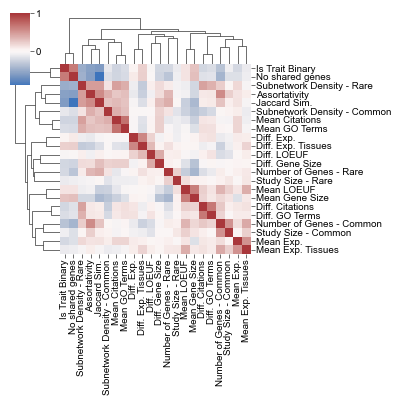

In [49]:
sns.clustermap(plot_feat.drop(columns='log2SizeOE').corr(method='spearman'), figsize=(4,4), cmap='vlag', center=0)
plt.savefig(os.path.join(figdir, 'input_network_feature_correlations2.svg'), bbox_inches='tight')

## Feature engineering + normalization

In [50]:
def compare_transforms(input_df, col, log=False):
    _, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=5, ncols=1, figsize=(5, 6))
    if log:
        X = np.log10(input_df[col].values).reshape(-1,1)
    else:
        X = input_df[col].values.reshape(-1,1)
    transformer1 = prep.QuantileTransformer(n_quantiles=len(X)).fit(X)
    transformer4 = prep.QuantileTransformer(output_distribution='normal', n_quantiles=len(X)).fit(X)
    transformer2 = prep.RobustScaler().fit(X)
    transformer3 = prep.PowerTransformer().fit(X)
    sns.histplot(X, ax=ax1)
    sns.histplot(transformer1.transform(X), ax=ax2)
    sns.histplot(transformer4.transform(X), ax=ax3)
    sns.histplot(transformer2.transform(X), ax=ax4)
    sns.histplot(transformer3.transform(X), ax=ax5)
    for i, trans in enumerate(['Input', 'Quant-Uni', 'Quant-Norm', 'Robust', 'Power']):
        [ax1, ax2, ax3, ax4, ax5][i].set_ylabel(trans)

### Transform features

In [155]:
# assign transforms
quant_norm= ['N_C', 'N_R', 'assortativity_rare_common', 'Mean_pli', 'DiffRC_pli', 'DiffRC_Length', 'DiffRC_n_mrna', 
            'Mean_mrna', 'DiffRC_mrna',  'Mean_Length', 'Mean_GO', 'DiffRC_GO'] #'Mean_Cite', 'DiffRC_Cite',
log_robust=[]
power = ['subnetwork_density_rare', 'subnetwork_density_common',
        'Mean_n_mrna', 'n_common', 'n_rare', 'jaccard']
none = ['binary', 'jaccard_zero']

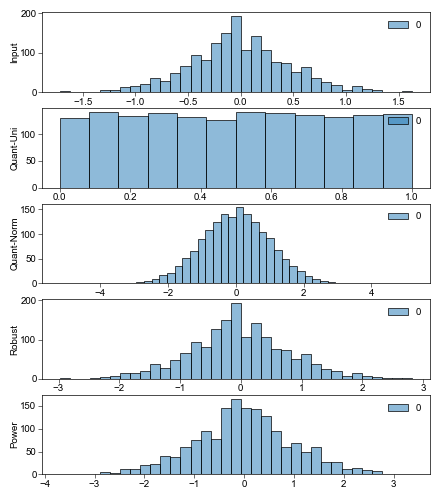

In [154]:
compare_transforms(all_feat, 'DiffRC_GO', log=False)

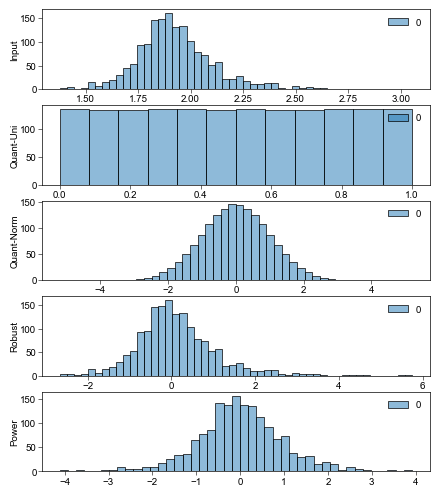

In [53]:
compare_transforms(all_feat, 'Mean_Cite', log=True)

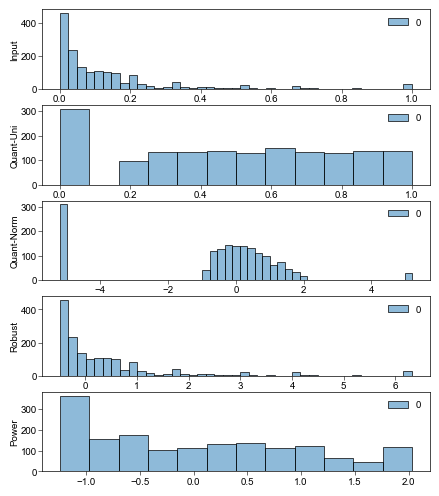

In [54]:
compare_transforms(all_feat, 'subnetwork_density_rare', log=False)

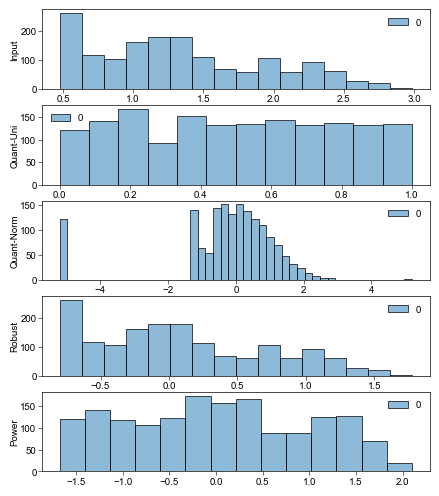

In [55]:
compare_transforms(all_feat, 'n_common', log=True)

In [56]:
# implement transfroms

In [156]:
all_x = []
x_qn = np.array(all_feat[quant_norm])
transformerqn = prep.QuantileTransformer(n_quantiles=len(x_qn), output_distribution='normal').fit(x_qn)
all_x.append(transformerqn.transform(x_qn))

#x_robust = np.log10(np.array(all_feat[log_robust]))
#transformer_robust = prep.RobustScaler().fit(x_robust)
#all_x.append(transformer_robust.transform(x_robust))

x_power = np.array(all_feat[power])
transformerp = prep.PowerTransformer().fit(x_power)
all_x.append(transformerp.transform(x_power))

all_x.append(np.array(all_feat[none]))

X = np.concatenate(all_x, axis=1)
scaler = prep.MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
X2 = sm.add_constant(X_scaled)

In [157]:
scaler2 = prep.StandardScaler().fit(X)
X_scaled2 = scaler2.transform(X)
X3 = sm.add_constant(X_scaled2)

### Transform target

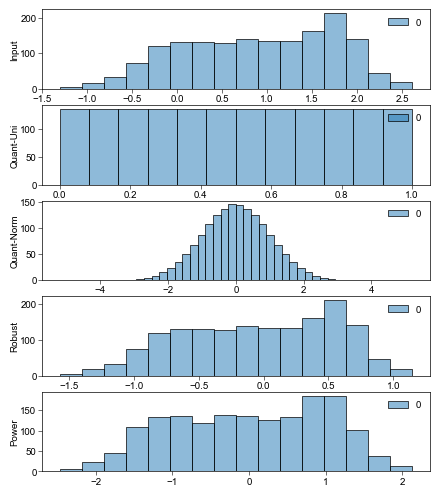

In [158]:
compare_transforms(all_feat, 'log2SizeOE', log=False)

In [159]:
y = all_feat.log2SizeOE.values.reshape(-1,1)
transformery = prep.QuantileTransformer(n_quantiles=len(y)).fit(y)
ynorm = transformery.transform(all_feat.log2SizeOE.values.reshape(-1,1))

## Fit models

### Elastic Net with cross-validation

In [160]:
from sklearn import linear_model
from sklearn.metrics import r2_score, explained_variance_score

In [161]:
feature_list = quant_norm + log_robust + power +none

In [162]:
feature_list

['N_C',
 'N_R',
 'assortativity_rare_common',
 'Mean_pli',
 'DiffRC_pli',
 'DiffRC_Length',
 'DiffRC_n_mrna',
 'Mean_mrna',
 'DiffRC_mrna',
 'Mean_Length',
 'Mean_GO',
 'DiffRC_GO',
 'subnetwork_density_rare',
 'subnetwork_density_common',
 'Mean_n_mrna',
 'n_common',
 'n_rare',
 'jaccard',
 'binary',
 'jaccard_zero']

In [163]:
def do_cv(X, y, feature_list):
    # assume X, y are already normalized numpy arrays or pandas DataFrame/Series

    # define the grid of alpha values to search
    alphas = np.logspace(-5, 1, 20)

    # set up a CV splitter (here 5-fold)
    cv = KFold(n_splits=5, shuffle=True, random_state=1984)

    # initialize ElasticNetCV with l1_ratio fixed at 0.5
    enet_cv = ElasticNetCV(
        l1_ratio=[.1,.25, .4, .5, .6, .7, .8,  .9, .95, .99, 1],
        alphas=alphas,
        cv=cv,
        max_iter=1000,
        random_state=10,
        fit_intercept=True
    )

    enet_cv.fit(X[:, 1:], y.squeeze())

    # best α found
    print(f"Optimal alpha: {enet_cv.alpha_:.4f}")
    print(f"Optimal l1_ratio: {enet_cv.l1_ratio_:.4f}")

    # coefficients and intercept
    print("Coefficients:", enet_cv.coef_)
    print("Intercept:", enet_cv.intercept_)
    
    y_pred = enet_cv.predict(X[:, 1:])

    print("Train MSE:", mean_squared_error(y.squeeze(), y_pred))
    print("Train R²:",  r2_score(y.squeeze(), y_pred))
    print("Coefficients:", [x for x in zip([feature_list+['intercept'], enet_cv.coef_)])
    return enet_cv

In [164]:
_ = do_cv(X2, ynorm, feature_list)

Optimal alpha: 0.0008
Optimal l1_ratio: 0.1000
Coefficients: [ 0.         -0.05640549  0.33287119 -0.11543571  0.01355642  0.14782864
 -0.09941549 -0.03172793  0.0352613   0.02710696 -0.05998425  0.02909728
  0.13112853  0.05536331 -0.00152768  0.03248833 -0.01479855  0.34499375
 -0.07907724 -0.10340771]
Intercept: 0.2839596524359551
Train MSE: 0.01949219926061204
Train R²: 0.7663806105795603
Coefficients: [('N_C', 0.0), ('N_R', -0.05640549387769183), ('assortativity_rare_common', 0.3328711892857802), ('Mean_pli', -0.11543570562833724), ('DiffRC_pli', 0.013556423104872446), ('DiffRC_Length', 0.14782864200116536), ('DiffRC_n_mrna', -0.09941549259279053), ('Mean_mrna', -0.03172793121502083), ('DiffRC_mrna', 0.035261303981350384), ('Mean_Length', 0.02710695938860939), ('Mean_GO', -0.05998425288636688), ('DiffRC_GO', 0.029097275027836888), ('subnetwork_density_rare', 0.13112853142680184), ('subnetwork_density_common', 0.05536331030813632), ('Mean_n_mrna', -0.0015276778991309508), ('n_commo

In [165]:
enet_cv2 = do_cv(X3, ynorm, feature_list)

Optimal alpha: 0.0144
Optimal l1_ratio: 0.1000
Coefficients: [ 0.         -0.00530273  0.03924193 -0.01168784  0.00030884  0.01567002
 -0.01023799 -0.00189512  0.00328501  0.00219148 -0.00514425  0.00308022
  0.03823507  0.0121296  -0.          0.00519877 -0.00285384  0.12121062
 -0.03619844 -0.05198023]
Intercept: 0.5000000000000001
Train MSE: 0.019495688625636266
Train R²: 0.7663387895764233
Coefficients: [('N_C', 0.0), ('N_R', -0.005302727478458296), ('assortativity_rare_common', 0.03924192594768125), ('Mean_pli', -0.011687841742734998), ('DiffRC_pli', 0.00030883718702891857), ('DiffRC_Length', 0.015670021964790247), ('DiffRC_n_mrna', -0.010237985805777923), ('Mean_mrna', -0.0018951231779525382), ('DiffRC_mrna', 0.0032850100854173612), ('Mean_Length', 0.002191475920362871), ('Mean_GO', -0.0051442514563772935), ('DiffRC_GO', 0.00308022440249358), ('subnetwork_density_rare', 0.0382350671054954), ('subnetwork_density_common', 0.012129596484364234), ('Mean_n_mrna', -0.0), ('n_common', 0

In [166]:
pd.DataFrame(X3,columns=feature_list+['intercept'], index=all_feat.index.values).N_R.describe()

count    1.629000e+03
mean    -2.180917e-17
std      1.000307e+00
min     -5.113853e+00
25%     -6.623668e-01
50%      2.702053e-03
75%      6.647415e-01
max      5.116227e+00
Name: N_R, dtype: float64

In [131]:
y_pred = enet_cv2.predict(X3[:,1:])

print("Train MSE:", mean_squared_error(ynorm.squeeze(), y_pred))
print("Train R²:",  r2_score(ynorm.squeeze(), y_pred))

Train MSE: 0.01944702048423153
Train R²: 0.7669220906871491


Text(0, 0.5, 'Predicted values')

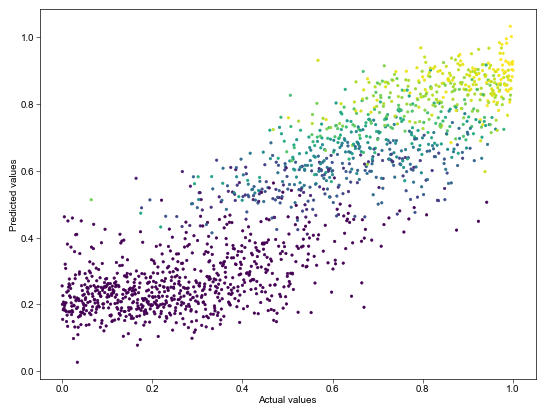

In [167]:
plt.scatter(ynorm, y_pred, s=3,c=X3[:, -3])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

In [168]:
residuals = np.subtract(ynorm.squeeze(), y_pred.squeeze())

In [169]:
resid_df = pd.DataFrame({'log2SizeOE_norm':ynorm.squeeze(), 'log2SizeOE':y.squeeze(), 'Prediction':y_pred, 'Residual':residuals}, index=all_feat.index.values)

In [170]:
resid_df.to_csv(os.path.join(keydir, 'residuals_mod4.tsv'), sep='\t')

In [171]:
from scipy.stats import spearmanr

In [172]:
spearmanr(ynorm, residuals)

SignificanceResult(statistic=0.5111939226436057, pvalue=3.7709123127261976e-109)

In [173]:
feature_list

['N_C',
 'N_R',
 'assortativity_rare_common',
 'Mean_pli',
 'DiffRC_pli',
 'DiffRC_Length',
 'DiffRC_n_mrna',
 'Mean_mrna',
 'DiffRC_mrna',
 'Mean_Length',
 'Mean_GO',
 'DiffRC_GO',
 'subnetwork_density_rare',
 'subnetwork_density_common',
 'Mean_n_mrna',
 'n_common',
 'n_rare',
 'jaccard',
 'binary',
 'jaccard_zero']

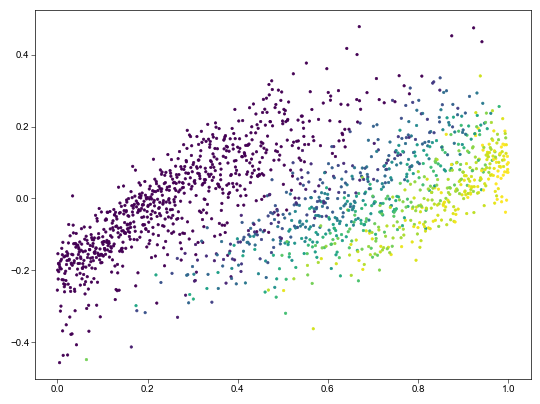

In [174]:
plt.scatter(ynorm, residuals, s=3, c=X3[:, -3])

In [175]:
print("Coefficients:", [x for x in zip(feature_list+['intercept'], enet_cv2.coef_)])

Coefficients: [('N_C', 0.0), ('N_R', -0.005302727478458296), ('assortativity_rare_common', 0.03924192594768125), ('Mean_pli', -0.011687841742734998), ('DiffRC_pli', 0.00030883718702891857), ('DiffRC_Length', 0.015670021964790247), ('DiffRC_n_mrna', -0.010237985805777923), ('Mean_mrna', -0.0018951231779525382), ('DiffRC_mrna', 0.0032850100854173612), ('Mean_Length', 0.002191475920362871), ('Mean_GO', -0.0051442514563772935), ('DiffRC_GO', 0.00308022440249358), ('subnetwork_density_rare', 0.0382350671054954), ('subnetwork_density_common', 0.012129596484364234), ('Mean_n_mrna', -0.0), ('n_common', 0.005198768327829139), ('n_rare', -0.0028538442059175616), ('jaccard', 0.12121061672919713), ('binary', -0.036198440943380296), ('jaccard_zero', -0.05198023098555928)]


In [176]:
best_alpha = enet_cv2.alpha_
best_l1=  enet_cv2.l1_ratio_
print('Best Alpha', best_alpha)
print('Best L1 Ratio', best_l1)

Best Alpha 0.01438449888287663
Best L1 Ratio 0.1


#### Perform bootstrapping analysis on coefficients

In [203]:
import numpy as np
from sklearn.linear_model import ElasticNet

B = 2000
coefs = np.zeros((B, X3[:, 1:].shape[1]))
r2 = []
intercepts = []

for b in range(B):
    # 1) sample with replacement
    idx = np.random.choice(len(ynorm), len(ynorm), replace=True)
    Xb, yb = X3[:, 1:][idx], ynorm[idx]

    # 2) refit only the final model
    model = ElasticNet(
        alpha=best_alpha,
        l1_ratio=best_l1,
        max_iter=1000,
        random_state=b
    ).fit(Xb, yb)

    coefs[b, :] = model.coef_
    yp = model.predict(Xb)
    r2.append( r2_score(yb.squeeze(), yp))
    intercepts.append(model.intercept_)
# 3) compute bootstrap SEs
se = coefs.std(axis=0)
print("Coefficient SEs:", se)


Coefficient SEs: [0.00280339 0.00355945 0.00537923 0.00515421 0.00319556 0.00453454
 0.00468641 0.00316393 0.00387393 0.00402843 0.0041267  0.00343824
 0.0048286  0.00460771 0.0028715  0.00475207 0.00371438 0.00660712
 0.00568973 0.0075199 ]


In [204]:
import numpy as np

# suppose `coefs` is your (B, n_features) array from the bootstrap
bootstrap_means = coefs.mean(axis=0)
bootstrap_sds   = coefs.std(axis=0, ddof=1) # ddof=1 for sample‐std

# print mean ± SE
for j, (m, se) in enumerate(zip(bootstrap_means, bootstrap_sds)):
    print(f"β_{j}: {m:.4f} \u00B1 {se:.4f}")

print(f"R2: {np.mean(r2):.3f} \u00B1 {np.std(r2):.4f}")
print(f"Intercept: {np.mean(intercepts):.3f} \u00B1 {np.std(intercepts):.4f}")

β_0: 0.0006 ± 0.0028
β_1: -0.0052 ± 0.0036
β_2: 0.0392 ± 0.0054
β_3: -0.0120 ± 0.0052
β_4: 0.0016 ± 0.0032
β_5: 0.0155 ± 0.0045
β_6: -0.0109 ± 0.0047
β_7: -0.0022 ± 0.0032
β_8: 0.0038 ± 0.0039
β_9: 0.0027 ± 0.0040
β_10: -0.0054 ± 0.0041
β_11: 0.0032 ± 0.0034
β_12: 0.0380 ± 0.0048
β_13: 0.0122 ± 0.0046
β_14: -0.0003 ± 0.0029
β_15: 0.0054 ± 0.0048
β_16: -0.0031 ± 0.0037
β_17: 0.1214 ± 0.0066
β_18: -0.0364 ± 0.0057
β_19: -0.0520 ± 0.0075
R2: 0.769 ± 0.0092
Intercept: 0.500 ± 0.0035


#### Calculate coefficient confidence intervals

In [205]:
import numpy as np

# coefs: array of shape (B, n_features), one row per bootstrap replicate

# Define your percentile bounds
lower_pct, upper_pct = 2.5, 97.5

# Compute the percentiles across the bootstrap replicates (axis=0)
ci_lower = np.percentile(coefs, lower_pct, axis=0)
ci_upper = np.percentile(coefs, upper_pct, axis=0)

# Print out the 95% bootstrap CIs for each coefficient
for j, (low, high) in enumerate(zip(ci_lower, ci_upper)):
    print(f"β_{feature_list[j]} 95% CI (percentile): [{low:.4f}, {high:.4f}]")


β_N_C 95% CI (percentile): [-0.0053, 0.0073]
β_N_R 95% CI (percentile): [-0.0126, 0.0000]
β_assortativity_rare_common 95% CI (percentile): [0.0286, 0.0498]
β_Mean_pli 95% CI (percentile): [-0.0220, -0.0019]
β_DiffRC_pli 95% CI (percentile): [-0.0044, 0.0093]
β_DiffRC_Length 95% CI (percentile): [0.0067, 0.0242]
β_DiffRC_n_mrna 95% CI (percentile): [-0.0202, -0.0017]
β_Mean_mrna 95% CI (percentile): [-0.0093, 0.0033]
β_DiffRC_mrna 95% CI (percentile): [-0.0021, 0.0118]
β_Mean_Length 95% CI (percentile): [-0.0035, 0.0120]
β_Mean_GO 95% CI (percentile): [-0.0141, 0.0000]
β_DiffRC_GO 95% CI (percentile): [-0.0012, 0.0112]
β_subnetwork_density_rare 95% CI (percentile): [0.0284, 0.0473]
β_subnetwork_density_common 95% CI (percentile): [0.0035, 0.0212]
β_Mean_n_mrna 95% CI (percentile): [-0.0072, 0.0061]
β_n_common 95% CI (percentile): [0.0000, 0.0163]
β_n_rare 95% CI (percentile): [-0.0117, 0.0019]
β_jaccard 95% CI (percentile): [0.1086, 0.1341]
β_binary 95% CI (percentile): [-0.0478, -0.025

#### Calculate p-values on coefficients

In [206]:
import numpy as np

B, n_features = coefs.shape
pvals = np.zeros(n_features)


for j in range(n_features):
    # fraction of bootstraps ≤ 0 and ≥ 0
    if np.sum(coefs[:, j] < 0) + np.sum(coefs[:, j] > 0) > 0:
        frac_le = (np.sum(coefs[:, j] < 0) + 1)/(B+1)
        frac_ge = (np.sum(coefs[:, j] > 0) + 1)/(B+1) 
        # two-sided q-value
        pvals[j] = min(1, 2 * min(frac_le, frac_ge)*n_features)
    else:
        pvals[j] = np.nan

# print results
for j, p in enumerate(pvals):
    print(f"coef #{feature_list[j]}: p ≈ {p:.8f}")


coef #N_C: p ≈ 1.00000000
coef #N_R: p ≈ 0.45977011
coef #assortativity_rare_common: p ≈ 0.01999000
coef #Mean_pli: p ≈ 0.01999000
coef #DiffRC_pli: p ≈ 1.00000000
coef #DiffRC_Length: p ≈ 0.01999000
coef #DiffRC_n_mrna: p ≈ 0.03998001
coef #Mean_mrna: p ≈ 1.00000000
coef #DiffRC_mrna: p ≈ 1.00000000
coef #Mean_Length: p ≈ 1.00000000
coef #Mean_GO: p ≈ 0.87956022
coef #DiffRC_GO: p ≈ 1.00000000
coef #subnetwork_density_rare: p ≈ 0.01999000
coef #subnetwork_density_common: p ≈ 0.01999000
coef #Mean_n_mrna: p ≈ 1.00000000
coef #n_common: p ≈ 0.59970015
coef #n_rare: p ≈ 1.00000000
coef #jaccard: p ≈ 0.01999000
coef #binary: p ≈ 0.01999000
coef #jaccard_zero: p ≈ 0.01999000


#### Export coefficients

In [207]:
import pandas as pd

coef_df = pd.DataFrame({
    'Feature': feature_list,
    'Coefficient': bootstrap_means,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper,
    'P-Val': pvals
})

coef_df['95% CI'] = coef_df.apply(
    lambda row: f"({row['CI Lower']:.3f}, {row['CI Upper']:.3f})",
    axis=1
)

order = [feature_names[x] for x in ['n_common', 'n_rare', 'subnetwork_density_common', 'subnetwork_density_rare', 'N_C', 'N_R', 
         'Mean_pli', 'DiffRC_pli', 'Mean_Length', 'DiffRC_Length', 'Mean_n_mrna', 'DiffRC_n_mrna',
         'Mean_mrna', 'DiffRC_mrna', 'Mean_GO', 'DiffRC_GO',
         'jaccard_zero',
        'jaccard', 'assortativity_rare_common', 'binary']]
coef_df['Feature'] = coef_df['Feature'].map(feature_names)
coef_df.set_index('Feature').loc[order, ( 'Coefficient', '95% CI', 'P-Val')].to_csv(os.path.join(figdir, 'elastic_net_coefs4_2000.tsv'), sep='\t')



In [183]:
min(coef_df['P-Val'])

0.0

## EN no CV

[('N_C', 0.49567758187844163), ('N_R', 0.0), ('assortativity_rare_common', -0.0049936517201849325), ('Mean_pli', 0.039563978627017174), ('DiffRC_pli', -0.011276799082421948), ('DiffRC_Length', 0.0), ('DiffRC_n_mrna', 0.015232222163045714), ('Mean_mrna', -0.00912079391489284), ('DiffRC_mrna', -0.0015480009479322547), ('Mean_Cite', 0.00148946441486286), ('DiffRC_Cite', -0.005955225964928138), ('Mean_Length', 0.00839573309649214), ('subnetwork_density_rare', 0.0005574964394994211), ('subnetwork_density_common', 0.035792288608915604), ('Mean_n_mrna', 0.013420595934530499), ('n_common', -0.0), ('n_rare', 0.003681451875866291), ('jaccard', -0.0032159218128969516), ('binary', 0.12407321960991079), ('jaccard_zero', -0.03593051597636538), ('intercept', -0.05046411823878076)]
0.7665773603889677


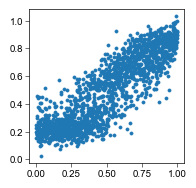

In [401]:
reg = linear_model.ElasticNet(alpha=best_alpha, l1_ratio=best_l1, fit_intercept=False)
reg.fit(X3, ynorm)
y_pred = reg.predict(X3)
print([x for x in zip(feature_list+['intercept'], reg.coef_)])
print(r2_score(ynorm, y_pred))
#print(explained_variance_score(ynorm, y_pred))
_ = plt.figure(figsize=(2,2))
plt.scatter(x=ynorm, y=y_pred, s=5)


### OLS Linear Regression

In [475]:
np.max(ynorm, axis=0)

array([1.])

In [490]:
model = sm.OLS(ynorm, X2).fit()
pred  = model.predict(X2)

In [491]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     515.4
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        12:23:37   Log-Likelihood:                 878.34
No. Observations:                1634   AIC:                            -1735.
Df Residuals:                    1623   BIC:                            -1675.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2321      0.042      5.575      0.0

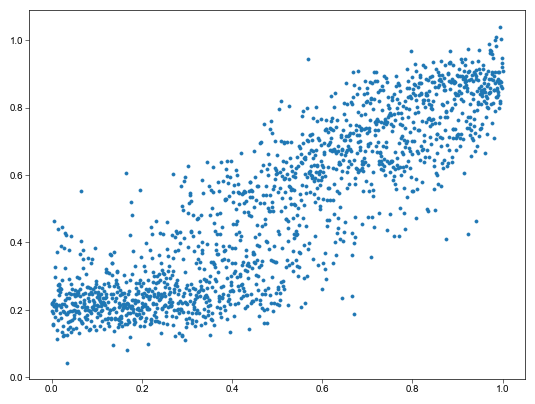

In [492]:
plt.scatter(x=ynorm, y=pred, s=5)

NameError: name 'fig_dir' is not defined

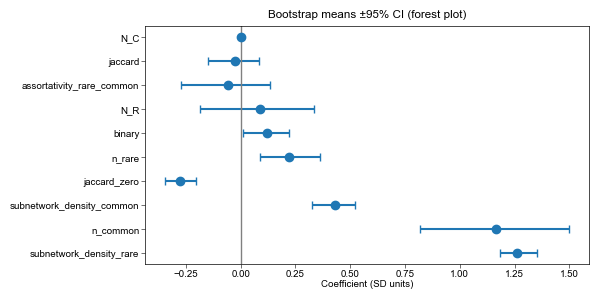

In [632]:
# bootstrap_means, ci_lower, ci_upper from before

order = np.argsort(np.abs(bootstrap_means))[::-1]
means = bootstrap_means[order]
low   = ci_lower[order]
high  = ci_upper[order]
names = [feature_list[i] for i in order]

fig, ax = plt.subplots(figsize=(6, len(names)*0.3))
y = np.arange(len(names))

ax.errorbar(means, y, xerr=[means - low, high - means], fmt='o', capsize=3)
ax.axvline(0, color='gray', linewidth=1)

ax.set_yticks(y)
ax.set_yticklabels(names)
ax.set_xlabel("Coefficient (SD units)")
ax.set_title("Bootstrap means ±95% CI (forest plot)")

plt.tight_layout()
plt.show()


# Visualize results

In [667]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_means_by_y_quantile(
    X, 
    y, 
    n_quantiles=10, 
    feature_names=None, 
    figsize=(10, 6)
):
    """
    For each of n_quantiles of y, compute the mean of each feature in X 
    and plot them as step‐plots.

    Parameters
    ----------
    X : array‐like, shape (n_samples, n_features)
        Your feature matrix (e.g. X2 without the intercept column).
    y : array‐like, shape (n_samples,)
        The target values used to form quantiles.
    n_quantiles : int, default=10
        Number of equal‐sized bins to cut y into.
    feature_names : list of str, length n_features, optional
        Names for each column of X for labeling the legend.
    figsize : tuple, default=(10,6)
        Size of the matplotlib figure.
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()

    # 1) assign each sample to a quantile bin
    try:
        bins = pd.qcut(y, q=n_quantiles, labels=False, duplicates='drop')
    except ValueError:
        # fallback: rank‐based binning if qcut fails (e.g. many ties)
        rank = np.argsort(np.argsort(y))
        bins = np.floor((rank / len(y)) * n_quantiles).astype(int)
        bins[bins == n_quantiles] = n_quantiles - 1

    unique_bins = np.unique(bins)
    n_bins = len(unique_bins)

    # 2) compute mean of each feature within each bin
    means = np.zeros((n_bins, X.shape[1]))
    for b in unique_bins:
        mask = bins == b
        means[b, :] = X[mask].mean(axis=0)

    # 3) plot as step plot
    x = np.arange(1, n_bins + 1)
    plt.figure(figsize=figsize)
    for j in range(X.shape[1]):
        label = feature_names[j] if feature_names is not None else f"Feat {j}"
        plt.step(x, means[:, j], where='mid', label=label)

    plt.xlabel("Y quantile")
    plt.ylabel("Mean feature value")
    plt.xticks(x)
    plt.title("Feature means across Y quantiles")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    plt.show()


In [677]:
feature_list

['N_C',
 'N_R',
 'assortativity_rare_common',
 'n_common',
 'n_rare',
 'jaccard',
 'subnetwork_density_rare',
 'subnetwork_density_common',
 'binary',
 'jaccard_zero']

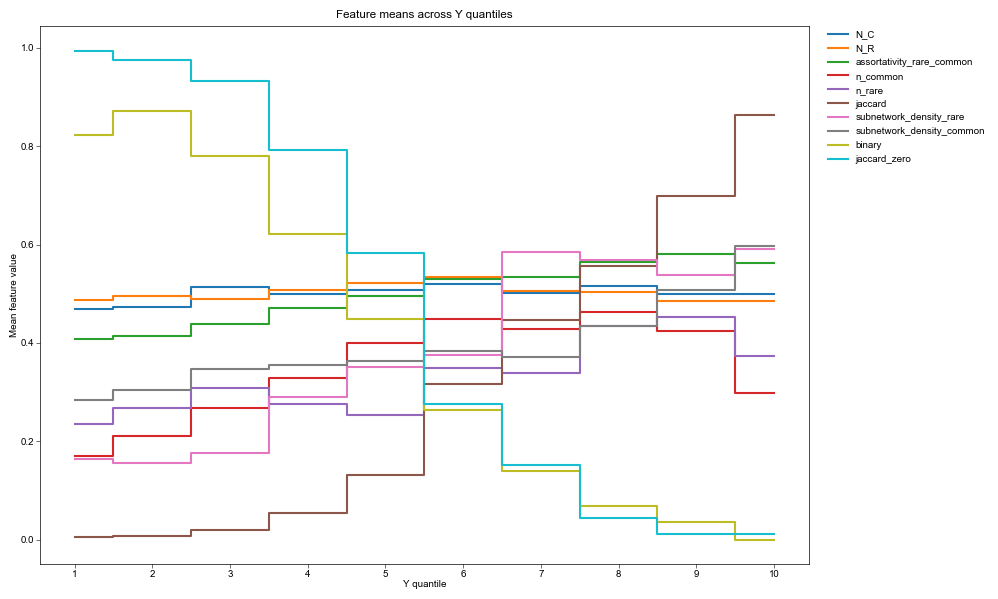

In [669]:
# drop intercept if present:
X_no_const = X2[:, 1:]

plot_feature_means_by_y_quantile(
    X_no_const,
    ynorm.squeeze(),
    n_quantiles=10,
    feature_names=feature_list
)


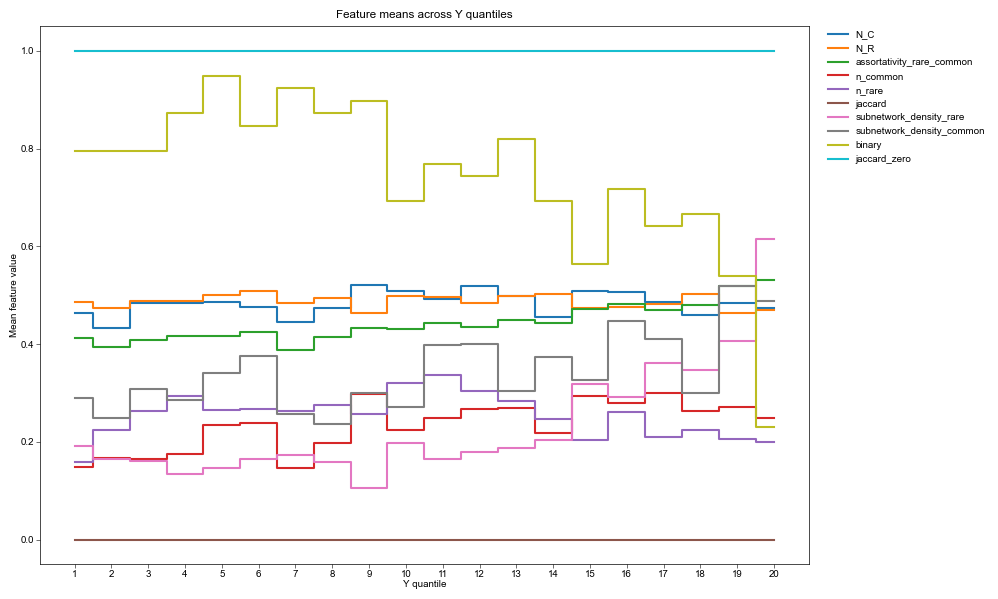

In [682]:
# Assume X2, ynorm, and features_list are already defined

# 1) Drop the intercept column
X_no_const = X2[:, 1:]

# 2) Build a mask for samples where the last feature == 1
#    (i.e. the final column of X_no_const)
mask = X_no_const[:, -1] == 1

# 3) Subset X and y
X_sub = X_no_const[mask]
y_sub = ynorm.squeeze()[mask]

# 4) Plot only those samples
plot_feature_means_by_y_quantile(
    X_sub,
    y_sub,
    n_quantiles=20,
    feature_names=feature_list
)


In [744]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_means_by_y_quantile_lines(
    X, 
    y, 
    n_quantiles=10, 
    feature_names=None, 
    subset_features=None,
    figsize=(10, 6),
    colors=None,
    ax=None
):
    """
    Bin y into n_quantiles, compute mean and standard error of each feature in X within each bin,
    and plot each feature's mean across quantiles as a line plot with error bars.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix (e.g. X2[:,1:]).
    y : array-like, shape (n_samples,)
        Target values used to form quantiles.
    n_quantiles : int
        Number of equal-sized bins to cut y into.
    feature_names : list of str, length n_features
        Names for each column of X.
    subset_features : list of str, optional
        Names of features to plot (must be a subset of feature_names).
    figsize : tuple
        Matplotlib figure size.
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()

    # 1) Assign each sample to a quantile bin
    try:
        bins = pd.qcut(y, q=n_quantiles, labels=False, duplicates='drop')
    except ValueError:
        # fallback: rank-based binning if qcut fails
        rank = np.argsort(np.argsort(y))
        bins = np.floor((rank / len(y)) * n_quantiles).astype(int)
        bins[bins == n_quantiles] = n_quantiles - 1

    unique_bins = np.unique(bins)
    n_bins = len(unique_bins)

    # 2) Compute mean and standard error of each feature within each bin
    means = np.zeros((n_bins, X.shape[1]))
    sems  = np.zeros_like(means)
    for b in unique_bins:
        vals = X[bins == b]
        means[b, :] = vals.mean(axis=0)
        sems[b, :]  = vals.std(axis=0, ddof=1) / np.sqrt(len(vals))

    # 3) Determine which features to plot
    if subset_features is not None and feature_names is not None:
        indices = [feature_names.index(f) for f in subset_features]
        plot_names = subset_features
    else:
        indices = list(range(X.shape[1]))
        plot_names = feature_names if feature_names is not None else [f"Feat {j}" for j in indices]

    # 4) Plot line plots with error bars
    x = np.arange(1, n_bins + 1)
    if ax is None:
        
        plt.figure(figsize=figsize)
        ax = plt.gca()
    plot_count=0
    for idx, name in zip(indices, plot_names):
        if colors is not None:
            ax.errorbar(x, means[:, idx], yerr=sems[:, idx], fmt='-o', capsize=3, label=name, markersize=1, color=colors[plot_count])
        else:
            ax.errorbar(x, means[:, idx], yerr=sems[:, idx], fmt='-o', capsize=3, label=name, markersize=1)
        plot_count+=1

    #ax.set_xlabel("Y quantile")
    ax.set_ylabel("Mean feature value")
    ax.set_xticks(x, labels=x*10)
    #plt.title("Feature means ± SE across Y quantiles")
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    #plt.tight_layout()
    #plt.show()

# Example usage:
# X_no_const = X2[:, 1:]
# plot_feature_means_by_y_quantile_lines(
#     X_no_const,
#     ynorm.squeeze(),
#     n_quantiles=10,
#     feature_names=features_list,
#     subset_features=['jaccard', 'binary']
# )

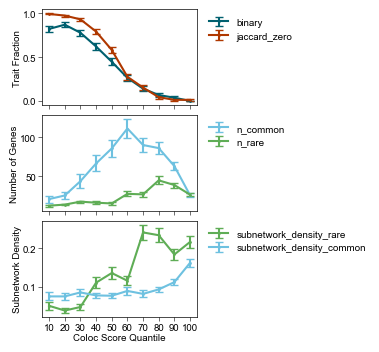

In [745]:
_, [ax2, ax1, ax3] = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(2, 4), gridspec_kw={'hspace':0.1})
X_no_const = np.array(all_feat[feature_list])
plot_feature_means_by_y_quantile_lines(
     X_no_const,
     ynorm.squeeze(),
     n_quantiles=10,
     feature_names=feature_list,
     subset_features=['n_common', 'n_rare'],
    figsize=(2,2),
    colors=[blue, green],
    ax=ax1
 )
ax1.set_ylabel('Number of Genes')

plot_feature_means_by_y_quantile_lines(
     X_no_const,
     ynorm.squeeze(),
     n_quantiles=10,
     feature_names=feature_list,
     subset_features=['binary', 'jaccard_zero'],
    figsize=(2,2),
    colors=[binary, shared],
    ax=ax2
 )
ax2.set_ylabel('Trait Fraction')

plot_feature_means_by_y_quantile_lines(
     X_no_const,
     ynorm.squeeze(),
     n_quantiles=10,
     feature_names=feature_list,
     subset_features=['subnetwork_density_rare', 'subnetwork_density_common'],
    figsize=(2,1.5),
    colors=[green, blue],
    ax=ax3
 )
ax3.set_ylabel('Subnetwork Density')

ax3.set_xlabel('Coloc Score Quantile')
plt.savefig(os.path.join(figdir, 'quantile_feature_plots.svg'), bbox_inches='tight')

#### Plot subnetwork density

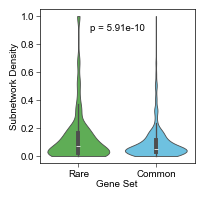

In [769]:
_ = plt.figure(figsize=(2,2))
sns.violinplot(all_feat.loc[:,('subnetwork_density_rare', 'subnetwork_density_common')].melt(var_name='varset', value_name='subnetwork_density'),
              cut=0, x='varset', y='subnetwork_density', hue='varset', palette=[green, blue], saturation=1)

_ = plt.xticks([0,1], labels=['Rare', 'Common'])
_ = plt.ylabel('Subnetwork Density')
_ = plt.xlabel('Gene Set')
p = wilcoxon(all_feat.subnetwork_density_rare, all_feat.subnetwork_density_common).pvalue
plt.text(x=0.5, y=0.9, s=f'p = {p:.2e}', horizontalalignment='center')
plt.savefig(os.path.join(figdir, 'violinplot_subnetwork_density_rare_common.svg'), bbox_inches='tight')

In [759]:
from scipy.stats import wilcoxon

In [761]:
(all_feat.subnetwork_density_rare - all_feat.subnetwork_density_common).describe()

count    1634.000000
mean        0.044866
std         0.224781
min        -1.000000
25%        -0.043540
50%         0.005582
75%         0.098219
max         1.000000
dtype: float64

5.910642465445585e-10

# ---------OLD----------------

In [144]:

Xa = np.array(input_df[['maxN', 'minN', 'meanCosine', 'Gene_ratio', 'binary']])
Xb = np.array(input_df[['jaccard', 'jaccard_zero']])
transformer1 = prep.QuantileTransformer(n_quantiles=len(Xa)).fit(Xa)
transformer2 = prep.RobustScaler().fit(Xb)
Xa_scaled = transformer1.transform(Xa)
Xb_scaled = transformer2.transform(Xb)
X_scaled = np.concatenate([Xa_scaled, Xb_scaled], axis=1)
X2 = sm.add_constant(X_scaled)

In [145]:
y = input_df.log2SizeOE.values.reshape(-1,1)

In [146]:
model = sm.OLS(y, X2).fit()
pred  = model.predict(X2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     189.2
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          2.64e-117
Time:                        12:07:27   Log-Likelihood:                -206.46
No. Observations:                 373   AIC:                             428.9
Df Residuals:                     365   BIC:                             460.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5164      0.085     17.924      0.0

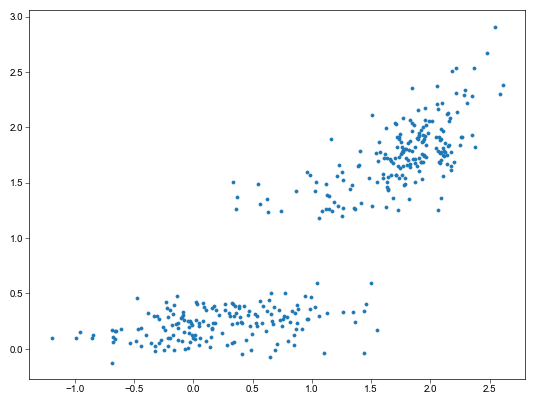

In [24]:
plt.scatter(x=y, y=pred, s=5)

### Ridge

[[ 0.         -0.28421145 -0.0264389   0.05827288 -0.19521659  0.23250801
   0.49838473 -1.05538424]]
0.7839693834793086
0.7839693834793086


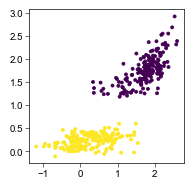

In [26]:

reg = linear_model.Ridge(alpha=0.5, fit_intercept=True)
reg.fit(X2, y)
y_pred = reg.predict(X2)
print(reg.coef_)
print(r2_score(y, y_pred))
print(explained_variance_score(y, y_pred))
_ = plt.figure(figsize=(2,2))
plt.scatter(x=y, y=y_pred, s=5, c=X2[:, -1])

### Lasso

[ 0.         -0.         -0.          0.         -0.          0.00871554
  0.44230194 -1.00020558]
0.7642337687053359
0.764233768705336


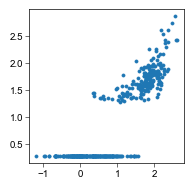

In [149]:
reg = linear_model.Lasso(alpha=0.02)
reg.fit(X2, y)
y_pred = reg.predict(X2)
print(reg.coef_)
print(r2_score(y, y_pred))
print(explained_variance_score(y, y_pred))
_ = plt.figure(figsize=(2,2))
plt.scatter(x=y, y=y_pred, s=5)

### Elastic Net

[ 0.         -0.          0.          0.         -0.         -0.
  0.49153498 -0.68731805]
0.7299130327276523
0.7299130327276523


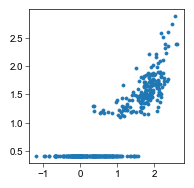

In [36]:
reg = linear_model.ElasticNet(alpha=0.1)
reg.fit(X2, y)
y_pred = reg.predict(X2)
print(reg.coef_)
print(r2_score(y, y_pred))
print(explained_variance_score(y, y_pred))
_ = plt.figure(figsize=(2,2))
plt.scatter(x=y, y=y_pred, s=5)

## Regress out Jaccard similarity

Regress out of the traits with shared genes only? Then Adjust to retain intercept?

In [95]:
input_df.head()

,log2SizeOE,logq,jaccard,maxN,minN,meanCosine,Gene_ratio,binary,jaccard_zero
EFO,,,,,,,,,
EFO_0004533,2.609069,250.0,0.333333,437896.0,256510.000000,0.910696,0.500000,0,0
EFO_0005091,2.584653,250.0,0.333333,443529.0,418415.969697,0.796182,0.750000,0,0
EFO_0006925,2.541330,250.0,0.458333,284044.0,146248.000000,0.901635,0.521739,0,0
EFO_0007805,2.474827,250.0,0.424242,400754.0,378175.226277,0.855174,0.880000,0,0
EFO_0004531,2.375897,250.0,0.176471,437354.0,182537.000000,0.846892,0.333333,0,0


In [182]:
Xb = np.array(input_df[['binary', 'jaccard','jaccard_zero']])
X2 = sm.add_constant(Xb)

In [183]:
y = input_df.log2SizeOE.values.reshape(-1,1)

In [184]:
model = sm.OLS(y, X2).fit()
pred  = model.predict(X2)

In [185]:
residuals = model.resid

In [186]:
y_adjusted = residuals + model.params[0]

In [187]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     417.0
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          3.93e-118
Time:                        12:12:45   Log-Likelihood:                -216.36
No. Observations:                 373   AIC:                             440.7
Df Residuals:                     369   BIC:                             456.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2542      0.060     21.055      0.0

(array([ 3.,  3.,  5.,  8.,  9., 14., 24., 34., 43., 55., 53., 50., 27.,
        18., 15.,  3.,  1.,  4.,  2.,  2.]),
 array([-0.06988439,  0.06726587,  0.20441613,  0.34156639,  0.47871665,
         0.61586691,  0.75301717,  0.89016743,  1.02731769,  1.16446795,
         1.30161821,  1.43876847,  1.57591873,  1.71306899,  1.85021925,
         1.98736952,  2.12451978,  2.26167004,  2.3988203 ,  2.53597056,
         2.67312082]),
 <BarContainer object of 20 artists>)

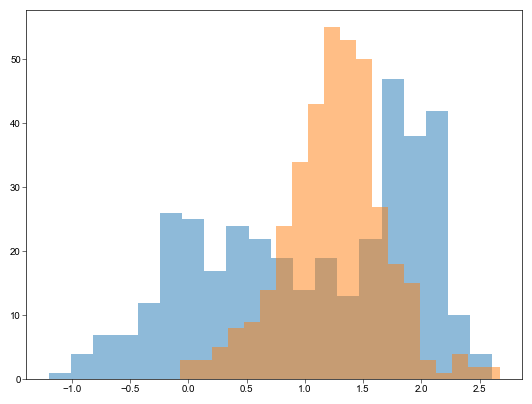

In [188]:
plt.hist(y, alpha=0.5, bins=20)
plt.hist(y_adjusted , alpha=0.5, bins=20)

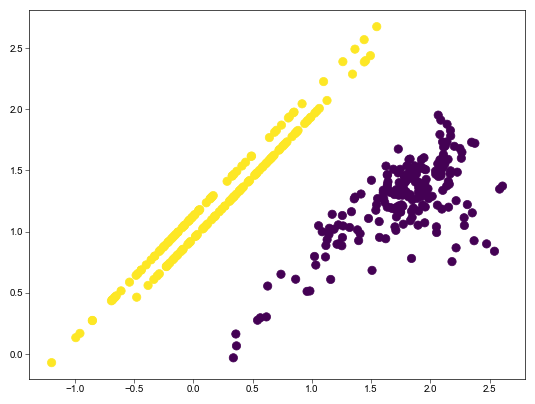

In [189]:
plt.scatter(y, y_adjusted, c=X2[:,-1])

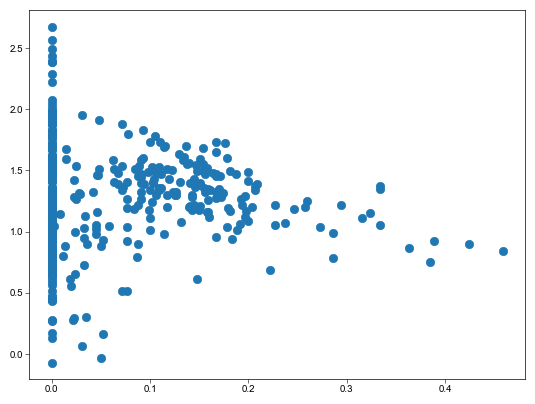

In [190]:
plt.scatter(input_df.jaccard, y_adjusted)

In [191]:
input_df['AdjustedColoc'] = y_adjusted

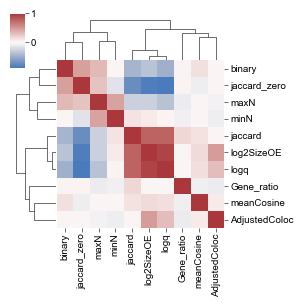

In [192]:
sns.clustermap(input_df.corr(), figsize=(3,3), cmap='vlag', center=0)

### Adjusted vs other input features

In [193]:
ya = input_df.AdjustedColoc.values.reshape(-1,1)

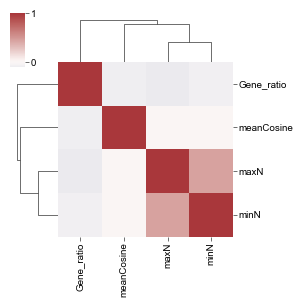

In [198]:
sns.clustermap(input_df[['maxN', 'minN', 'meanCosine', 'Gene_ratio']].corr(), figsize=(3,3), cmap='vlag', center=0)

In [203]:
Xa = np.array(input_df[['maxN','minN' ,'meanCosine', 'Gene_ratio']])
transformer1 = prep.QuantileTransformer(n_quantiles=len(Xa)).fit(Xa)
Xa_scaled = transformer1.transform(Xa)
X2 = sm.add_constant(Xa)

In [204]:
model2 = sm.OLS(ya, X2).fit()
pred  = model2.predict(X2)

In [205]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.723
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0293
Time:                        12:14:16   Log-Likelihood:                -210.92
No. Observations:                 373   AIC:                             431.8
Df Residuals:                     368   BIC:                             451.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1531      0.193      5.984      0.0

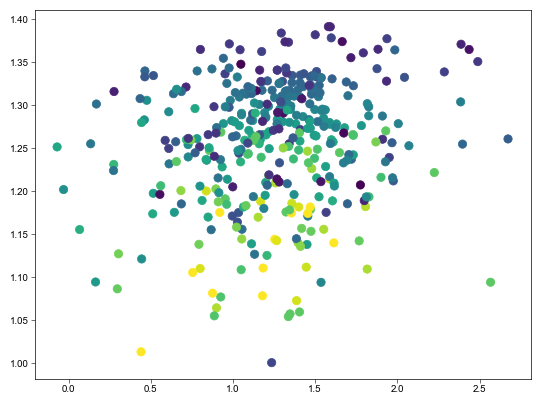

In [206]:
plt.scatter(ya, pred, c=X2[:, -1])

# Network features

In [263]:
input_df.head()

,log2SizeOE,logq,jaccard,maxN,minN,meanCosine,Gene_ratio,binary,jaccard_zero,AdjustedColoc
EFO,,,,,,,,,,
EFO_0004533,2.609069,250.0,0.333333,437896.0,256510.000000,0.910696,0.500000,0,0,1.371502
EFO_0005091,2.584653,250.0,0.333333,443529.0,418415.969697,0.796182,0.750000,0,0,1.347085
EFO_0006925,2.541330,250.0,0.458333,284044.0,146248.000000,0.901635,0.521739,0,0,0.839675
EFO_0007805,2.474827,250.0,0.424242,400754.0,378175.226277,0.855174,0.880000,0,0,0.899741
EFO_0004531,2.375897,250.0,0.176471,437354.0,182537.000000,0.846892,0.333333,0,0,1.720714


In [484]:
Xnet = net_df.merge(input_df.loc[:, ('AdjustedColoc')].reset_index(), on='EFO')

In [485]:
Xnet.head()

,varset,subnetwork_density,n_components,average_degree,subnetwork_average_degree,clustering,subnetwork_clustering,assortativity,average_path,subnetAssort,n_rare,n_common,n_overlap,trait_pair,EFO,Modularity,SubnetMod,AdjustedColoc
0,rare,0.250000,3,314.125000,1.750000,0.204771,0.291667,0.005247,1.821429,NaN,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533,0.000003,NaN,1.371502
1,common,0.116667,7,284.000000,1.750000,0.236188,0.200000,0.005575,2.050000,NaN,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533,0.000007,NaN,1.371502
2,overlap,0.266667,2,289.666667,1.333333,0.201191,0.000000,0.004378,1.866667,NaN,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533,0.000002,NaN,1.371502
3,rare_common,0.130719,8,295.500000,2.222222,0.235343,0.303704,0.006835,2.026144,0.007724,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533,0.000009,0.065,1.371502
4,rare,0.227273,2,400.916667,2.500000,0.228749,0.302778,0.005615,1.787879,NaN,12,16,7,34662886_EFO_0005091_GCST90025950_EFO_0005091,EFO_0005091,0.000007,NaN,1.347085


## Feature correlations + values

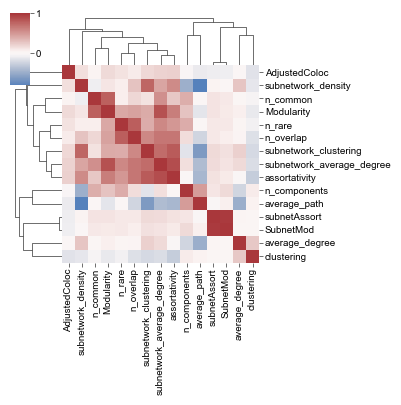

In [486]:
sns.clustermap(Xnet[Xnet.varset=='rare_common'].drop(columns=['varset', 'EFO', 'trait_pair']).corr(), figsize=(4,4), cmap='vlag', center=0)

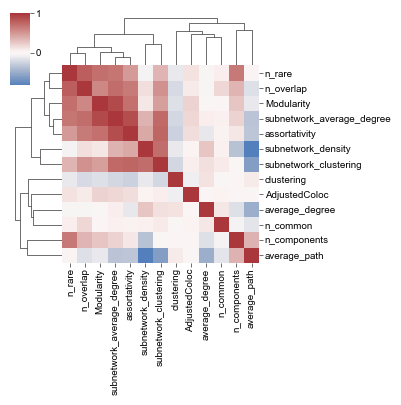

In [489]:
sns.clustermap(Xnet[Xnet.varset=='rare'].drop(columns=['varset', 'EFO', 'trait_pair', 'subnetAssort', 'SubnetMod']).dropna().corr(), figsize=(4,4), cmap='vlag', center=0)

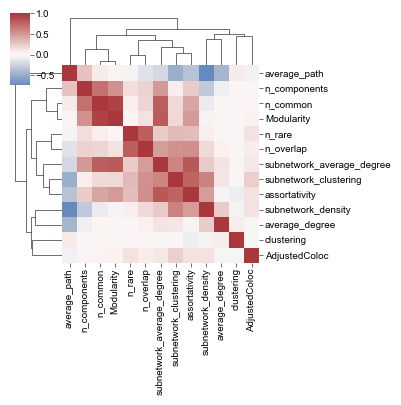

In [490]:
sns.clustermap(Xnet[Xnet.varset=='common'].drop(columns=['varset', 'EFO', 'trait_pair', 'subnetAssort', 'SubnetMod']).dropna().corr(), figsize=(4,4), cmap='vlag', center=0)

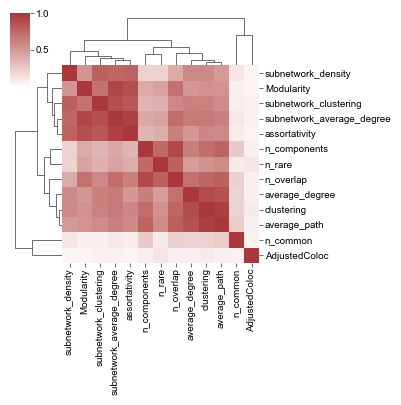

In [491]:
sns.clustermap(Xnet[Xnet.varset=='overlap'].drop(columns=['varset', 'EFO', 'trait_pair', 'subnetAssort', 'SubnetMod']).dropna().corr(), figsize=(4,4), cmap='vlag', center=0)

## Feature normalization

In [330]:
Xnet.columns

Index(['varset', 'subnetwork_density', 'n_components', 'average_degree',
       'subnetwork_average_degree', 'clustering', 'subnetwork_clustering',
       'assortativity', 'average_path', 'subnetAssort', 'n_rare', 'n_common',
       'n_overlap', 'trait_pair', 'EFO', 'AdjustedColoc'],
      dtype='object')

In [339]:
sep_net = Xnet.loc[Xnet.varset.isin(['rare', 'common']), ('EFO', 'average_degree', 'clustering')]


In [340]:
sep_net = sep_net.groupby('EFO').agg(
    deg_min=pd.NamedAgg(column="average_degree", aggfunc="min"),
    deg_max=pd.NamedAgg(column="average_degree", aggfunc="max"),
    deg_mean=pd.NamedAgg(column="average_degree", aggfunc="mean"),
    c_min=pd.NamedAgg(column="clustering", aggfunc="min"),
    c_max=pd.NamedAgg(column="clustering", aggfunc="max"),
    c_mean=pd.NamedAgg(column="clustering", aggfunc="mean")
).reset_index()

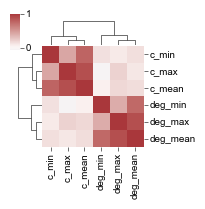

In [341]:
sns.clustermap(sep_net.corr(numeric_only=True, method='spearman'), figsize=(2,2), cmap='vlag', center=0)

In [342]:
both_net = Xnet.loc[Xnet.varset.isin(['rare_common']), ('EFO', 'subnetAssort', 'subnetwork_clustering','clustering', 'average_degree')]


In [343]:
all_x = sep_net.merge(both_net, on='EFO').merge(input_df.reset_index().loc[:, ('EFO', 'AdjustedColoc', 'log2SizeOE', 'jaccard')])

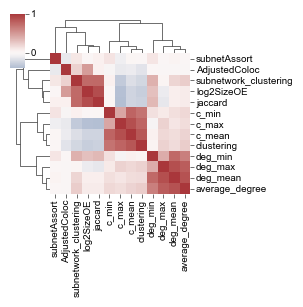

In [344]:
sns.clustermap(all_x.corr(numeric_only=True, method='spearman'), figsize=(3,3), cmap='vlag', center=0)

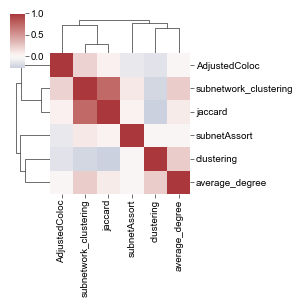

In [348]:
sns.clustermap(all_x.loc[:, ('subnetAssort', 'subnetwork_clustering', 'clustering', 'average_degree', 'AdjustedColoc', 'jaccard')].corr(numeric_only=True, method='spearman'), figsize=(3,3), cmap='vlag', center=0)

In [364]:
X_net2 = all_x.loc[:, ('subnetAssort', 'subnetwork_clustering', 'clustering', 'average_degree', 'AdjustedColoc', 'jaccard')]

In [365]:
X_net2.describe()

,subnetAssort,subnetwork_clustering,clustering,average_degree,AdjustedColoc,jaccard
count,332.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,-0.054839,0.216871,0.274273,425.991004,1.254218,0.069432
std,0.228442,0.175120,0.030132,112.359697,0.432772,0.088884
min,-1.000000,0.000000,0.187181,77.333333,-0.069884,0.000000
25%,-0.116046,0.000000,0.255479,364.285714,0.998819,0.000000
50%,-0.037155,0.230769,0.270136,418.705263,1.281609,0.023810
75%,0.018871,0.360920,0.289703,468.428571,1.505130,0.126582
max,1.000000,0.742857,0.370070,969.538462,2.673121,0.458333


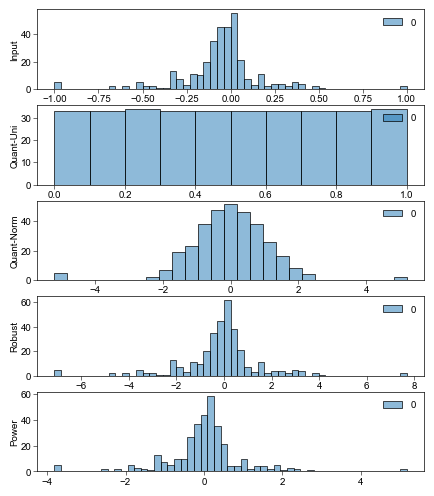

In [366]:
compare_transforms(X_net2, 'subnetAssort', log=False)

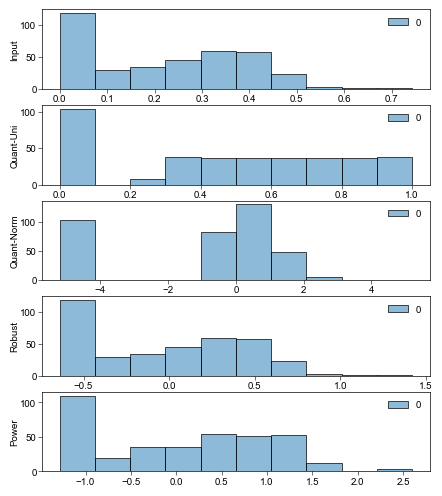

In [354]:
compare_transforms(X_net2, 'subnetwork_clustering', log=False)

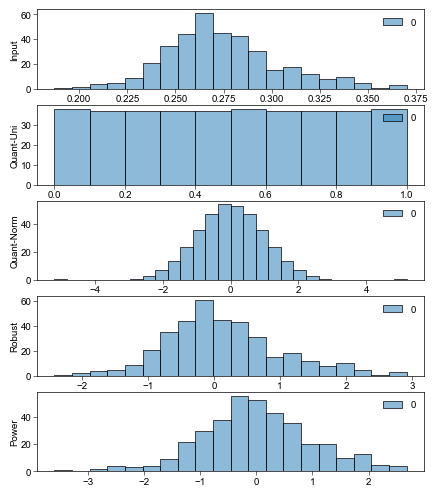

In [355]:
compare_transforms(X_net2, 'clustering', log=False)

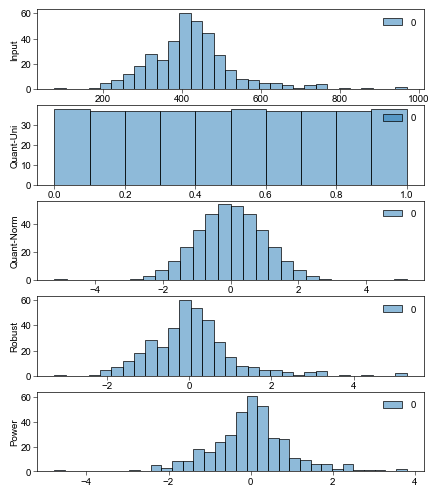

In [356]:
compare_transforms(X_net2, 'average_degree', log=False)

In [ ]:
# clustering=0 means there are no triangles in the data.

# Power transform for: subnetAssort, clustering, average degree, 
# subnetwork_clustering is a little bit suss, but there are a lot of zeros so...

## Regression Analysis

In [402]:
import statsmodels.api as sm
Xa = np.array(X_net2[['subnetAssort', 'clustering', 'average_degree', 'subnetwork_clustering']].fillna(0))
#Xb = np.array(input_df[['subnetwork_clustering']])
transformer1 = prep.PowerTransformer().fit(Xa)
#transformer2 = prep.RobustScaler().fit(Xb)
Xa_scaled = transformer1.transform(Xa)
#Xb_scaled = transformer2.transform(Xb)
#X_scaled = np.concatenate([Xa_scaled, Xb_scaled], axis=1)
X_net3 = sm.add_constant(Xa_scaled)

In [403]:
y = X_net2.AdjustedColoc.values.reshape(-1,1)
y2 = X_net2.jaccard.values.reshape(-1,1)

In [407]:
model = sm.OLS(y, X_net3).fit()
model2 = sm.OLS(y2, X_net3).fit()
pred  = model.predict(X_net3)
pred2 = model2.predict(X_net3)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     6.551
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           4.22e-05
Time:                        15:37:50   Log-Likelihood:                -203.53
No. Observations:                 373   AIC:                             417.1
Df Residuals:                     368   BIC:                             436.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2542      0.022     57.618      0.0

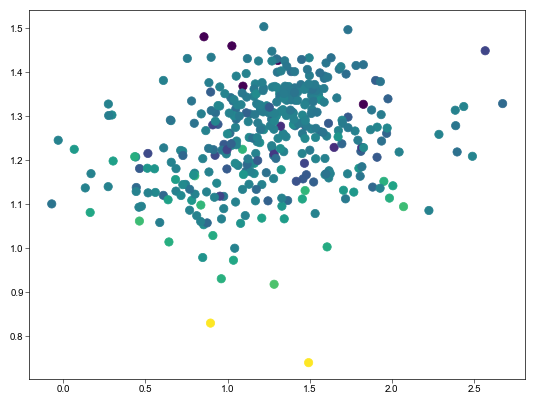

In [414]:
print(model.summary())
plt.scatter(y, pred, c=X_net3[:, -4])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     67.43
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           9.13e-43
Time:                        15:36:53   Log-Likelihood:                 476.60
No. Observations:                 373   AIC:                            -943.2
Df Residuals:                     368   BIC:                            -923.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0694      0.004     19.753      0.0

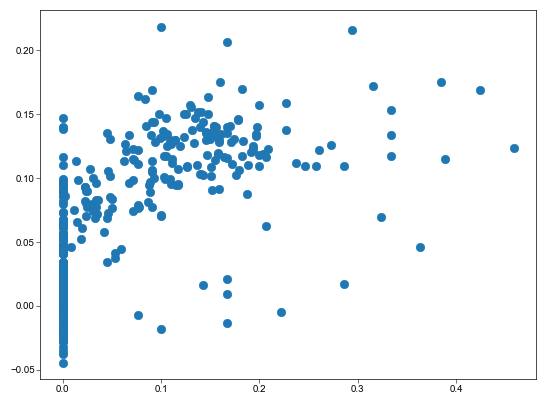

In [412]:
print(model2.summary())
plt.scatter(y2, pred2)

In [419]:
all_x.

(332, 14)

<Axes: xlabel='subnetAssort', ylabel='AdjustedColoc'>

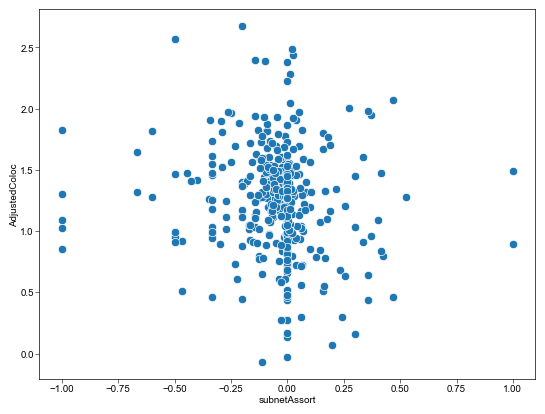

In [424]:
sns.scatterplot(all_x.fillna(0), x='subnetAssort', y='AdjustedColoc')

<Axes: xlabel='subnetwork_clustering', ylabel='AdjustedColoc'>

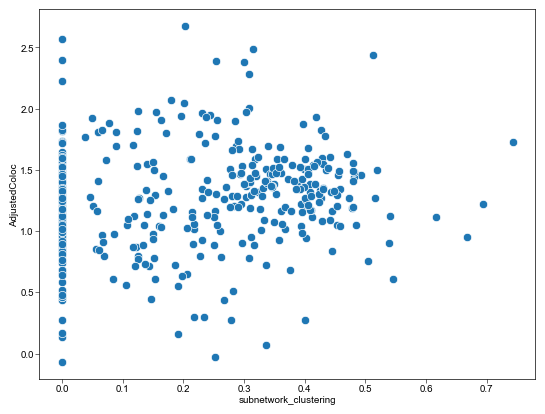

In [425]:
sns.scatterplot(all_x.fillna(0), x='subnetwork_clustering', y='AdjustedColoc')

<Axes: xlabel='subnetwork_clustering', ylabel='jaccard'>

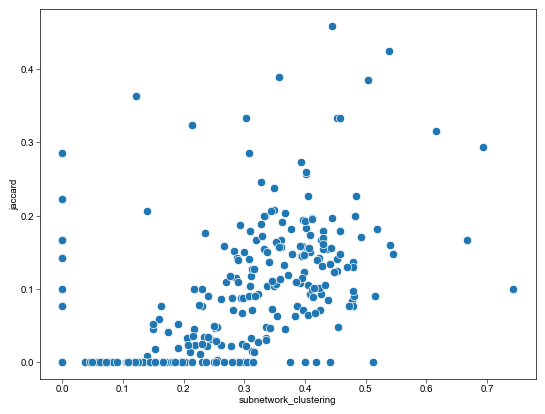

In [428]:
sns.scatterplot(all_x.fillna(0), x='subnetwork_clustering', y='jaccard')

## Feature normalization

# Bio features